# Preparing Data for EDA and ML+Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import os
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

import missingno as msno

##### 0. Import Dataset

In [2]:
df_original = pd.read_csv('output/dataset_worldbank_transposed.csv')
df_original

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),"Prevalence of underweight, weight for age (% of children under 5)","Community health workers (per 1,000 people)",...,Forest area (% of land area),Forest area (sq. km),Land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (sq. km),Rural land area where elevation is below 5 meters (% of total land area),Rural land area where elevation is below 5 meters (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16221,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,NaN,NaN,NaN,...,45.570273,176288.6,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16222,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,33.9,NaN,NaN,...,45.451183,175827.9,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16223,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,NaN,NaN,NaN,...,45.332093,175367.2,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
16224,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,39.5,9.7,NaN,...,45.213002,174906.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 1. Remove Noisy Country

In [3]:
countries_to_drop = ['Channel Islands',
 'Curacao',
 'Isle of Man',
 'Kosovo',
 'Monaco',
 'Northern Mariana Islands',
 'Not classified',
 'San Marino',
 'Sint Maarten (Dutch part)',
 'South Sudan',
 'St. Martin (French part)']

df_original = df_original[~df_original['Country Name'].isin(countries_to_drop)]
df_original.reset_index(inplace=True, drop=True)
df_original

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),"Prevalence of underweight, weight for age (% of children under 5)","Community health workers (per 1,000 people)",...,Forest area (% of land area),Forest area (sq. km),Land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (sq. km),Rural land area where elevation is below 5 meters (% of total land area),Rural land area where elevation is below 5 meters (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15550,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,NaN,NaN,NaN,...,45.570273,176288.6,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
15551,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,33.9,NaN,NaN,...,45.451183,175827.9,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
15552,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,NaN,NaN,NaN,...,45.332093,175367.2,NaN,NaN,NaN,NaN,NaN,10.339925,41.876696,162000.0
15553,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,39.5,9.7,NaN,...,45.213002,174906.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 2. Drop Missing Values > 50%

In [4]:
# function to visualize the proportion of missing value
def visual_nan(df, name="", isSorted=False, savePlot=True):
    
    sort = ''
    if isSorted:
        df=df[df.isna().sum().sort_values().keys()]
        sort = '_sorted'
    missing_value = df.isna().melt(value_name="missing")

    ax = sns.displot(data=missing_value,
                      y="variable",
                      hue="missing",
                      multiple="fill",
                      height=10,
                      aspect=1.5)
    plt.xlabel("Proportion of missing value")
    plt.title(f"Missing values of {name}")
    
    if savePlot:
        filename = name.split('.')
        plt.savefig(f"plot/{filename[0]}{sort}.png")

    return ax

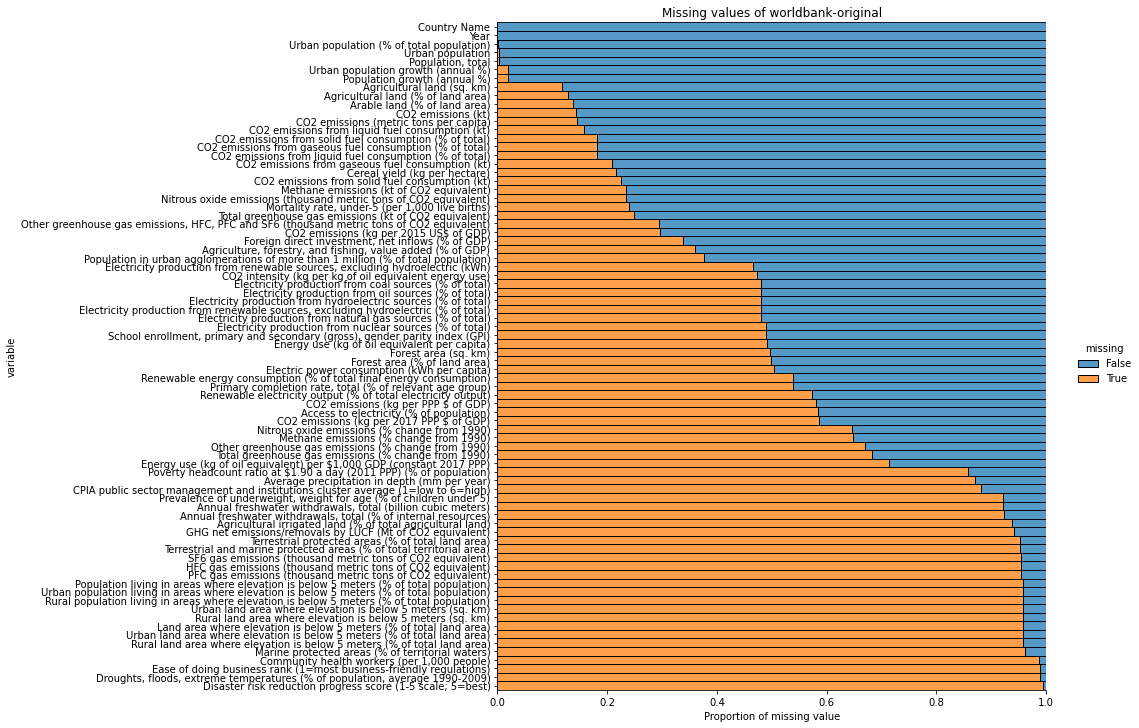

In [5]:
visual_nan(df_original, 'worldbank-original', isSorted=True)

In [6]:
# function to display the number of missing values and missing ratio
def missing_ratio_summary(df):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)

    display(missing.sort_values(by=['ratio']))
    
# function to return a list of columns with more than x% of missing values 
def get_X_missing(df, X):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)
    
    missing_list = missing[missing['ratio'] > X]['col'].tolist()
    return missing_list
    
missing_ratio_summary(df_original)

,col,missing,ratio
0,Country Name,0,0.00
1,Year,0,0.00
2,Urban population (% of total population),9,0.06
3,Urban population,42,0.27
5,"Population, total",42,0.27
...,...,...,...
17,Marine protected areas (% of territorial waters),14961,96.18
9,"Community health workers (per 1,000 people)",15342,98.63
15,Ease of doing business rank (1=most business-f...,15369,98.80
25,"Droughts, floods, extreme temperatures (% of p...",15387,98.92


In [7]:
missing = pd.DataFrame(df_original.isna().sum(), columns=['missing'])
missing.reset_index(inplace=True)
missing.rename(columns={'index':'col'}, inplace=True)
missing['ratio'] = (missing['missing']/len(df_original)*100).round(2)
missing_list = missing[missing['ratio'] > 50]['col'].tolist()
missing_list

['Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
 'Prevalence of underweight, weight for age (% of children under 5)',
 'Community health workers (per 1,000 people)',
 'Primary completion rate, total (% of relevant age group)',
 'CPIA public sector management and institutions cluster average (1=low to 6=high)',
 'Ease of doing business rank (1=most business-friendly regulations)',
 'Terrestrial and marine protected areas (% of total territorial area)',
 'Marine protected areas (% of territorial waters)',
 'Terrestrial protected areas (% of total land area)',
 'Annual freshwater withdrawals, total (% of internal resources)',
 'Annual freshwater withdrawals, total (billion cubic meters)',
 'Population living in areas where elevation is below 5 meters (% of total population)',
 'Urban population living in areas where elevation is below 5 meters (% of total population)',
 'Rural population living in areas where elevation is below 5 meters (% of total population)',
 '

In [8]:
df_original = df_original.drop(columns=missing_list)

In [9]:
len(missing_list)

38

In [10]:
# Remove CO2 columns
y_cols = [c for c in df_original.columns if c.lower()[:13] == 'co2 emissions']
y_cols

['CO2 emissions from solid fuel consumption (% of total)',
 'CO2 emissions from solid fuel consumption (kt)',
 'CO2 emissions (metric tons per capita)',
 'CO2 emissions from liquid fuel consumption (% of total)',
 'CO2 emissions from liquid fuel consumption (kt)',
 'CO2 emissions (kt)',
 'CO2 emissions (kg per 2015 US$ of GDP)',
 'CO2 emissions from gaseous fuel consumption (% of total)',
 'CO2 emissions from gaseous fuel consumption (kt)']

##### Encoding

In [11]:
col_list = [col for col in df_original.columns.tolist() if df_original[col].dtype.name == "object"]
df_oh = df_original[col_list]
df = df_original.drop(col_list, 1)
df_oh = pd.get_dummies(df_oh)
df = pd.concat([df, df_oh], axis=1)
df.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Country Name_Uzbekistan,Country Name_Vanuatu,"Country Name_Venezuela, RB",Country Name_Vietnam,Country Name_Virgin Islands (U.S.),Country Name_West Bank and Gaza,Country Name_World,"Country Name_Yemen, Rep.",Country Name_Zambia,Country Name_Zimbabwe
0,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [12]:
cols = [c for c in df.columns if c.lower()[:13] != 'co2 emissions']
df = df[df.columns.intersection(cols)]
df.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Country Name_Uzbekistan,Country Name_Vanuatu,"Country Name_Venezuela, RB",Country Name_Vietnam,Country Name_Virgin Islands (U.S.),Country Name_West Bank and Gaza,Country Name_World,"Country Name_Yemen, Rep.",Country Name_Zambia,Country Name_Zimbabwe
0,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


##### Feature Selection (Boruta)

In [13]:
rf = RandomForestRegressor(n_jobs=-1, max_depth =64, random_state=1)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=1)

In [14]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [15]:
import pandas as pd
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(df), index=df.index, columns=df.columns)
df = pd.DataFrame(x_scaled)

In [16]:
# import pandas as pd
# import numpy as np

# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.fillna(0, inplace=True)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     # return df[indices_to_keep].astype(np.float64)

Fill missing value with median

In [17]:
df.fillna(df.median(), inplace=True)
df.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),...,Country Name_Uzbekistan,Country Name_Vanuatu,"Country Name_Venezuela, RB",Country Name_Vietnam,Country Name_Virgin Islands (U.S.),Country Name_West Bank and Gaza,Country Name_World,"Country Name_Yemen, Rep.",Country Name_Zambia,Country Name_Zimbabwe
0,0.000000,0.497319,0.000006,0.804419,0.000006,0.349816,0.107501,0.677666,0.144489,0.167958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016667,0.497166,0.000006,0.802059,0.000007,0.368966,0.107501,0.677666,0.144489,0.167958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.033333,0.497013,0.000006,0.798663,0.000007,0.336030,0.107501,0.677666,0.144489,0.167958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.050000,0.496850,0.000006,0.796055,0.000007,0.311056,0.107501,0.677666,0.144489,0.167958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.066667,0.496696,0.000006,0.795049,0.000007,0.301090,0.107501,0.677666,0.144489,0.167958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
y = df_original['CO2 emissions (metric tons per capita)']
y = y.fillna(y.median())
X = df
colnames = X.columns

In [19]:
feat_selector.fit(X.values, y.values.ravel())
boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

In [20]:
print('---------Top 10 for CO2 emissions (metric tons per capita)----------')
display(boruta_score.head(20))

print('---------Bottom 10 for CO2 emissions (metric tons per capita)----------')
boruta_score.tail(10)

---------Top 10 for CO2 emissions (metric tons per capita)----------


,Features,Score
0,Year,1.00
42,Country Name_Aruba,1.00
15,Energy use (kg of oil equivalent per capita),1.00
5,Population growth (annual %),1.00
6,"Mortality rate, under-5 (per 1,000 live births)",1.00
223,Country Name_Qatar,1.00
14,CO2 intensity (kg per kg of oil equivalent ene...,1.00
1,Urban population (% of total population),1.00
11,Methane emissions (kt of CO2 equivalent),1.00
12,Total greenhouse gas emissions (kt of CO2 equi...,0.99


---------Bottom 10 for CO2 emissions (metric tons per capita)----------


,Features,Score
197,Country Name_Nepal,0.03
280,Country Name_West Bank and Gaza,0.03
241,Country Name_South Asia,0.03
250,Country Name_Sub-Saharan Africa (excluding hig...,0.02
242,Country Name_South Asia (IDA & IBRD),0.02
226,Country Name_Rwanda,0.02
249,Country Name_Sub-Saharan Africa (IDA & IBRD co...,0.01
178,Country Name_Mali,0.01
35,Country Name_American Samoa,0.00
202,Country Name_Niger,0.00


Text(0.5, 1.0, 'Boruta all Features')

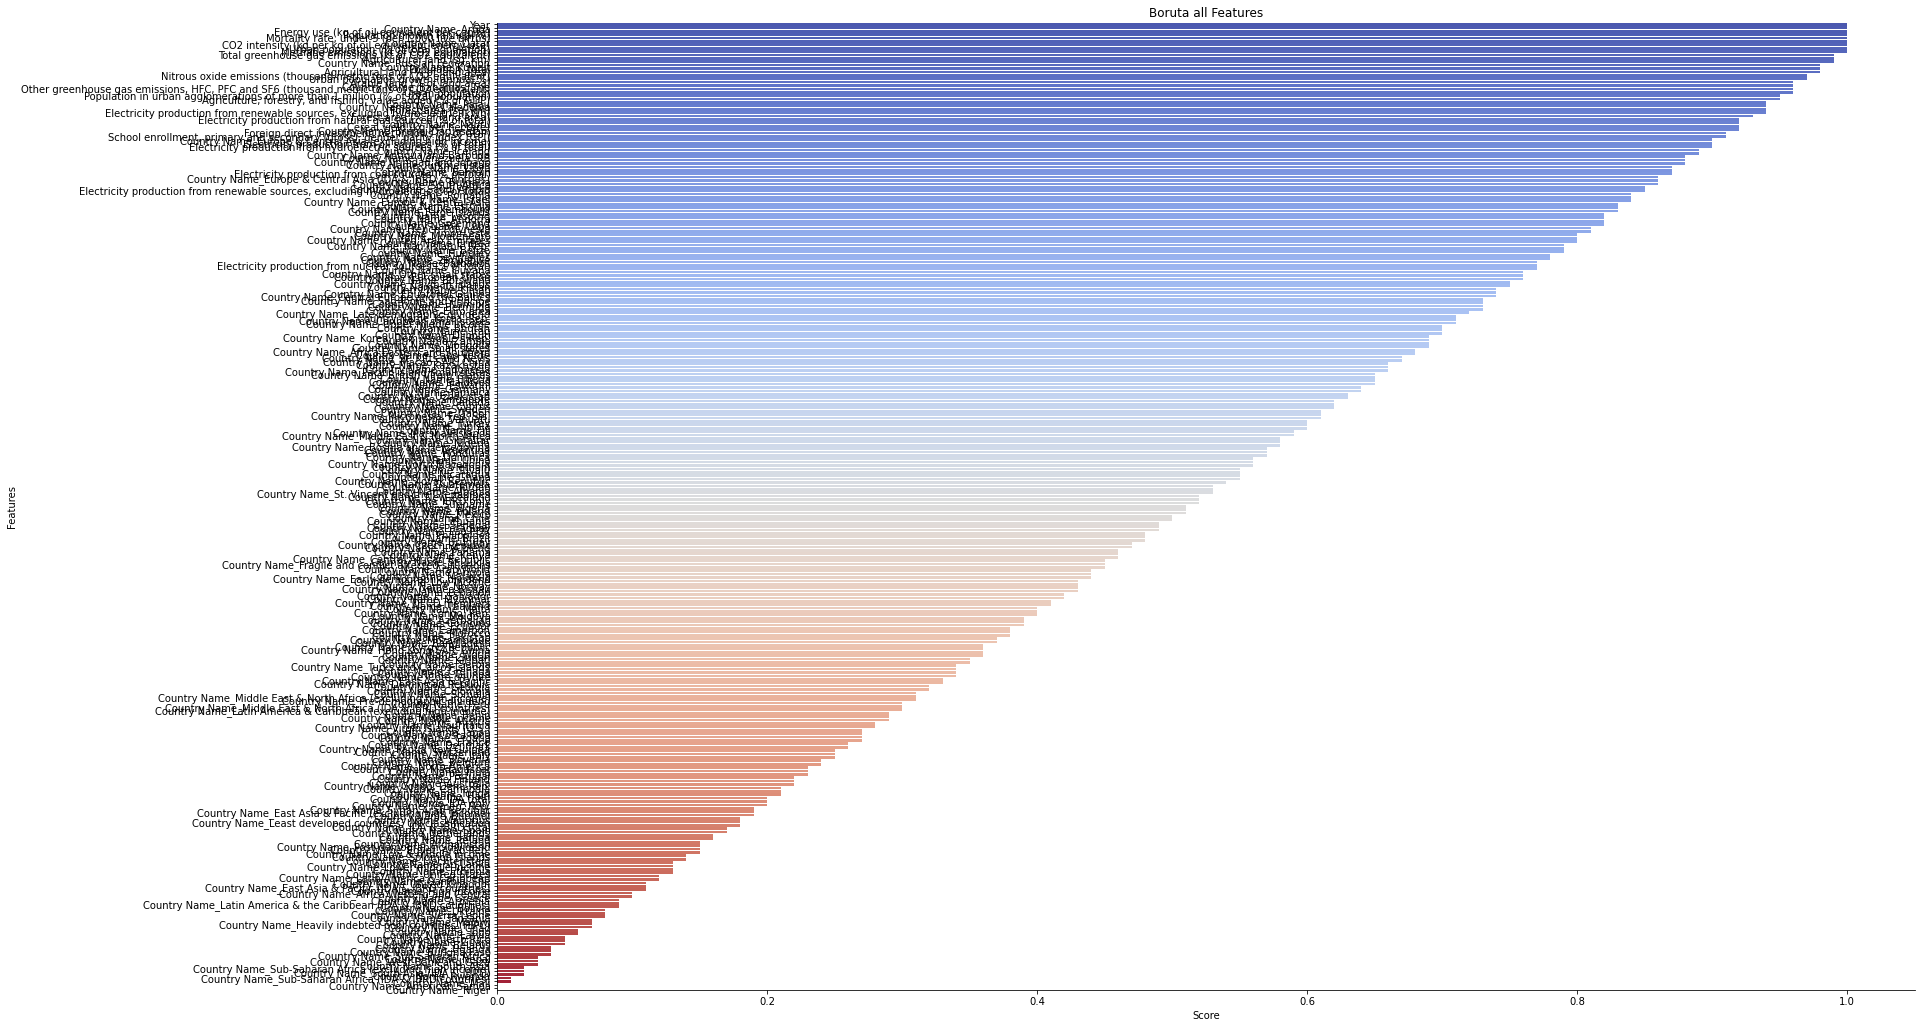

In [21]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[:], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta all Features")

In [22]:
for feat in list(zip(X.columns, feat_selector.ranking_, feat_selector.support_)):
    print('Features: {:<30} Rank： {}, Keep: {}'.format(feat[0],feat[1],feat[2]))

Features: Year                           Rank： 1, Keep: True
Features: Urban population (% of total population) Rank： 1, Keep: True
Features: Urban population               Rank： 12, Keep: False
Features: Urban population growth (annual %) Rank： 9, Keep: False
Features: Population, total              Rank： 7, Keep: False
Features: Population growth (annual %)   Rank： 1, Keep: True
Features: Mortality rate, under-5 (per 1,000 live births) Rank： 2, Keep: False
Features: School enrollment, primary and secondary (gross), gender parity index (GPI) Rank： 27, Keep: False
Features: Agriculture, forestry, and fishing, value added (% of GDP) Rank： 15, Keep: False
Features: Population in urban agglomerations of more than 1 million (% of total population) Rank： 15, Keep: False
Features: Nitrous oxide emissions (thousand metric tons of CO2 equivalent) Rank： 10, Keep: False
Features: Methane emissions (kt of CO2 equivalent) Rank： 1, Keep: True
Features: Total greenhouse gas emissions (kt of CO2 equi

In [23]:
for feat in list(zip(X.columns, feat_selector.ranking_, feat_selector.support_)):
    if feat[2]:
        print('Features: {:<60} Rank： {}, Keep: {}'.format(feat[0],feat[1],feat[2]))

Features: Year                                                         Rank： 1, Keep: True
Features: Urban population (% of total population)                     Rank： 1, Keep: True
Features: Population growth (annual %)                                 Rank： 1, Keep: True
Features: Methane emissions (kt of CO2 equivalent)                     Rank： 1, Keep: True
Features: CO2 intensity (kg per kg of oil equivalent energy use)       Rank： 1, Keep: True
Features: Energy use (kg of oil equivalent per capita)                 Rank： 1, Keep: True
Features: Country Name_Aruba                                           Rank： 1, Keep: True
Features: Country Name_Qatar                                           Rank： 1, Keep: True


After running feature selection for a few times, we discover that the columns that are highly related to **CO2 emissions (metric tons per capita)** are:

- Year
- Urban population (% of total population)
- Population growth (annual %)
- Methane emissions (kt of CO2 equivalent)
- CO2 intensity (kg per kg of oil equivalent energy use)
- Energy use (kg of oil equivalent per capita)

In [24]:
# a list of columns to keep
col_to_keep = [
    "Year", 
    "Urban population (% of total population)", 
    "Population growth (annual %)", 
    "Methane emissions (kt of CO2 equivalent)",
    "CO2 intensity (kg per kg of oil equivalent energy use)",
    "Energy use (kg of oil equivalent per capita)"
]

In [25]:
df_final = df_original[col_to_keep]
df_final

,Year,Urban population (% of total population),Population growth (annual %),Methane emissions (kt of CO2 equivalent),CO2 intensity (kg per kg of oil equivalent energy use),Energy use (kg of oil equivalent per capita)
0,1960,50.776,NaN,NaN,NaN,NaN
1,1961,50.761,2.236462,NaN,NaN,NaN
2,1962,50.746,1.432843,NaN,NaN,NaN
3,1963,50.730,0.823502,NaN,NaN,NaN
4,1964,50.715,0.580334,NaN,NaN,NaN
...,...,...,...,...,...,...
15550,2016,32.296,1.549294,11380.0,NaN,NaN
15551,2017,32.237,1.459406,11560.0,NaN,NaN
15552,2018,32.209,1.410382,11850.0,NaN,NaN
15553,2019,32.210,1.421142,NaN,NaN,NaN


##### Imputation

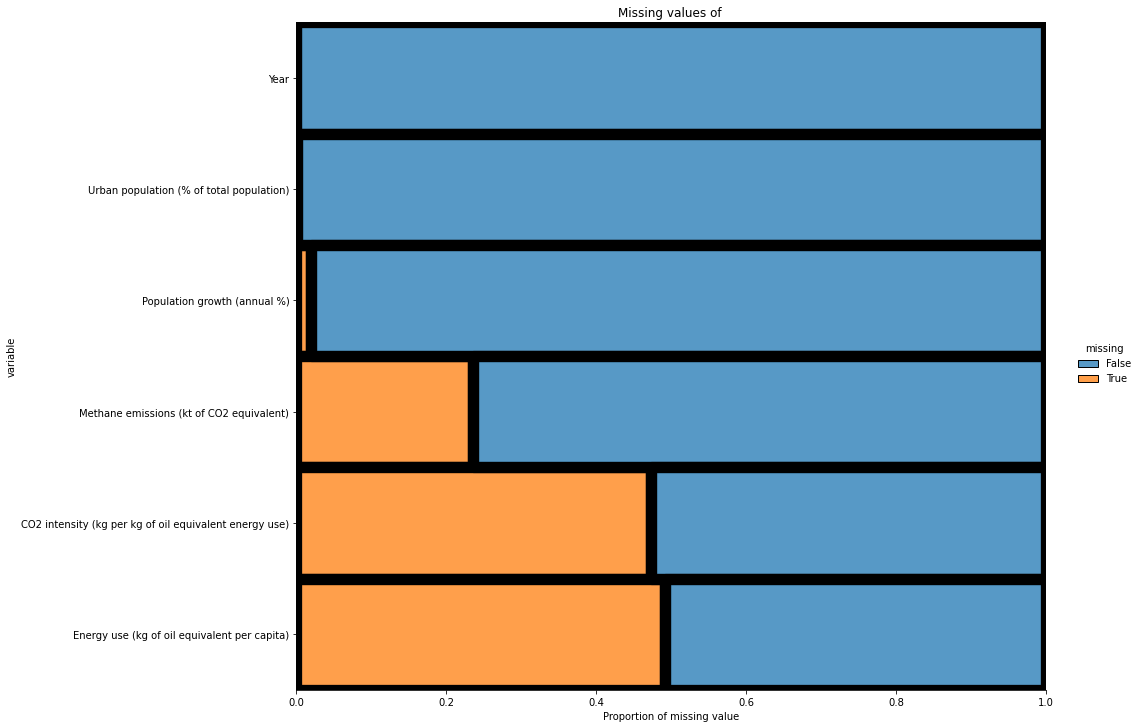

In [26]:
visual_nan(df_final, name="", isSorted=False, savePlot=False)

<AxesSubplot:>

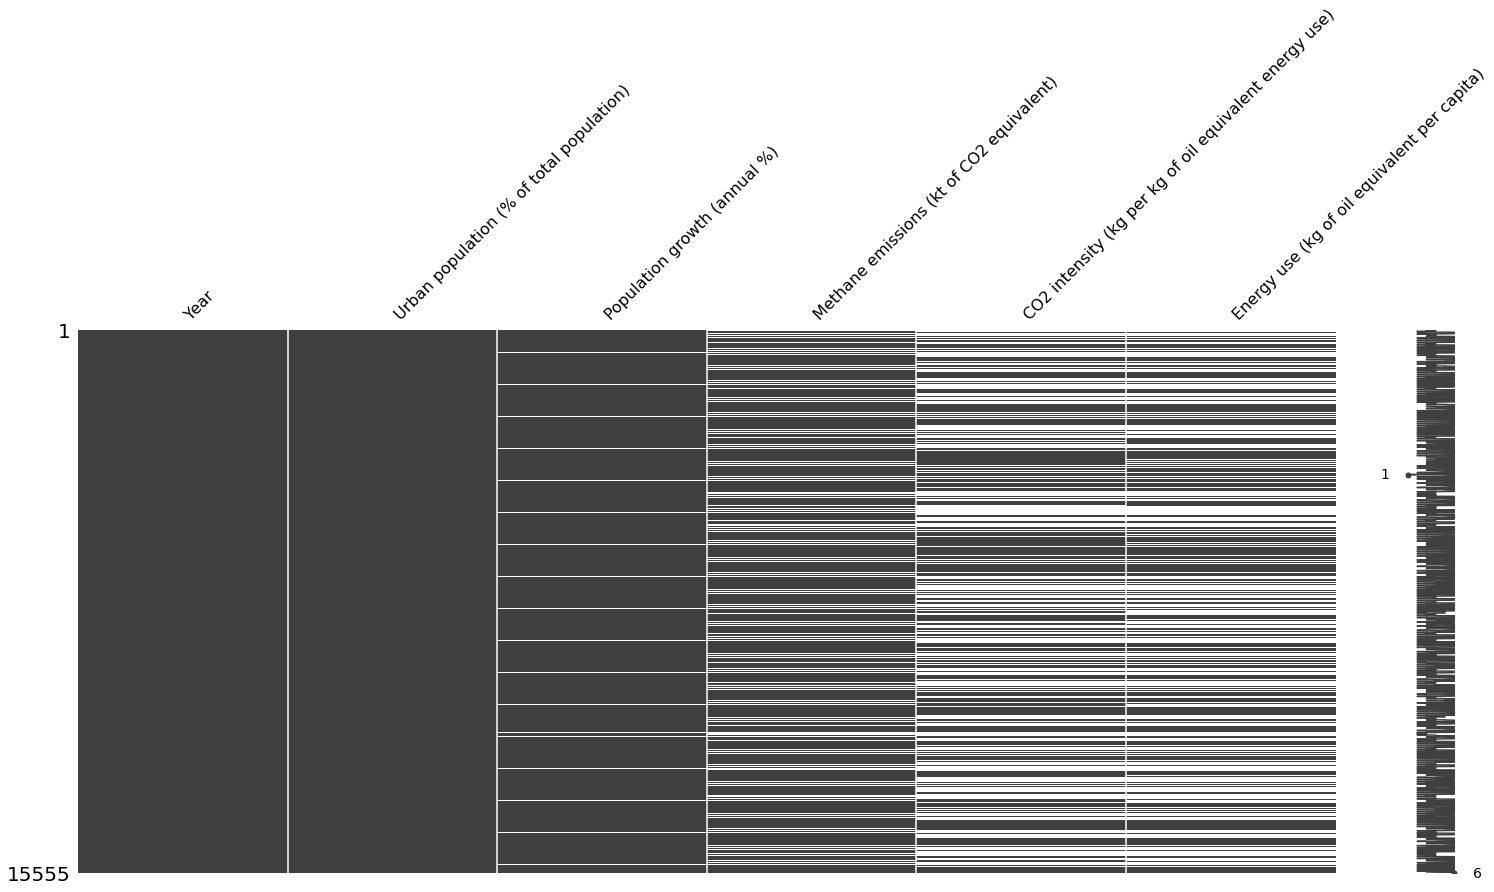

In [27]:
msno.matrix(df_final)

In [28]:
imp = IterativeImputer(max_iter=10, random_state=2022)
imp.fit(df_final)

df_imputed_array = imp.transform(df_final)

In [29]:
df_imputed = pd.DataFrame(df_imputed_array, columns=col_to_keep)
df_imputed['Year'] = df_imputed['Year'].astype('int')
df_imputed['Country Name'] = df_original['Country Name']

cols = df_imputed.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_imputed = df_imputed[cols]
df_imputed

,Country Name,Year,Urban population (% of total population),Population growth (annual %),Methane emissions (kt of CO2 equivalent),CO2 intensity (kg per kg of oil equivalent energy use),Energy use (kg of oil equivalent per capita)
0,Aruba,1960,50.776,2.236858,283583.062664,2.863799,1914.972357
1,Aruba,1961,50.761,2.236462,283586.955510,2.845710,1913.773722
2,Aruba,1962,50.746,1.432843,284129.953488,2.773063,1738.412785
3,Aruba,1963,50.730,0.823502,284542.777005,2.713592,1605.106452
4,Aruba,1964,50.715,0.580334,284709.618454,2.679013,1551.267704
...,...,...,...,...,...,...,...
15550,Zimbabwe,2016,32.296,1.549294,11380.000000,1.421311,438.447490
15551,Zimbabwe,2017,32.237,1.459406,11560.000000,1.396260,414.750358
15552,Zimbabwe,2018,32.209,1.410382,11850.000000,1.374628,402.110531
15553,Zimbabwe,2019,32.210,1.421142,288207.742939,1.383934,425.865325


In [30]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15555 entries, 0 to 15554
Data columns (total 7 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Country Name                                            15555 non-null  object 
 1   Year                                                    15555 non-null  int32  
 2   Urban population (% of total population)                15555 non-null  float64
 3   Population growth (annual %)                            15555 non-null  float64
 4   Methane emissions (kt of CO2 equivalent)                15555 non-null  float64
 5   CO2 intensity (kg per kg of oil equivalent energy use)  15555 non-null  float64
 6   Energy use (kg of oil equivalent per capita)            15555 non-null  float64
dtypes: float64(5), int32(1), object(1)
memory usage: 790.0+ KB


In [31]:
df_imputed.to_csv('output/dataset_worldbank_imputed.csv', index=False)
print('Completed!')

Completed!


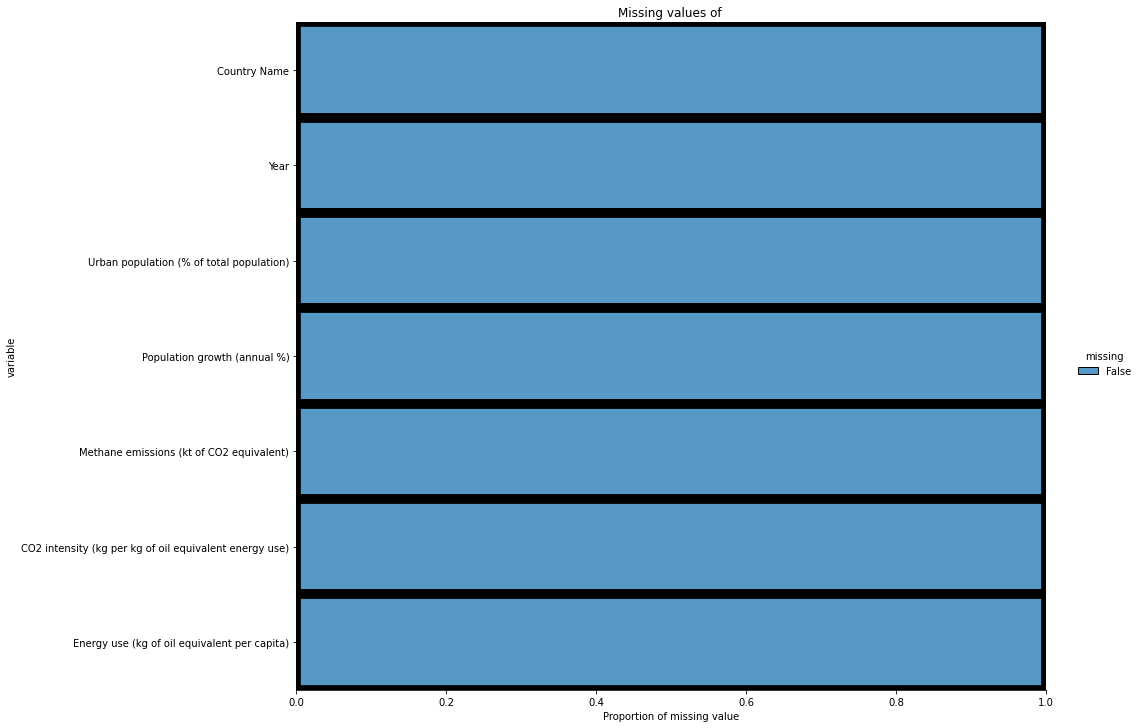

In [32]:
visual_nan(df_imputed, name="", isSorted=False, savePlot=False)

In [ ]:
# def multivariate_imputation(df, iso_code, country):
    
#     N = 20
#     df_train = df.iloc[:-N] 
#     df_test = df[-N:] # last N years

#     print(f'Training years: {df_train.shape[0]}')
#     print(f'Test years: {df_test.shape[0]}')
    
#     visual_nan(df_train.shape[0], name="", isSorted=False, savePlot=True)
    
#     imp = IterativeImputer(max_iter=10, random_state=2022)
#     imp.fit(df_train.iloc[:, :49]) # exclude last column

#     df_predict_array = imp.transform(df_test.iloc[:, :49])

#     columns = df.columns.tolist()[:49]
#     df_predict = pd.DataFrame(df_predict_array, columns=columns) # array to df
    
#     df_predict['iso_code'] = iso_code
#     df_predict['country'] = country
#     df_predict['year'] = df_test['Year'].to_list() # predicted years

#     return df_predict

# def multivariate_imputation(df):
    
#     imp = IterativeImputer(max_iter=10, random_state=2022)
#     imp.fit(df.iloc[:, 1:]) # exclude last column

#     df_predict_array = imp.transform(df[:, 1:])

#     columns = df[:, 1:].columns.tolist()
#     df_predict = pd.DataFrame(df_predict_array, columns=columns) # array to df

#     return df_predict

In [ ]:
# df = multivariate_imputation(df_original)
# df.head()